In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 4.1MB/s 


In [0]:
#coding=utf-8
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, model_selection, neighbors, svm
from skmultilearn.model_selection import iterative_train_test_split
np.random.seed(1)
from tensorflow import random
random.set_seed(1)

FINGERPRINT = "FCFP0"
df = pd.read_csv("/content/drive/My Drive/PY/Chemo/data/{0}.csv".format(FINGERPRINT))
df = df.drop(columns=["row ID","StringFP"])

# FINGERPRINT = "Top50"
# df = pd.read_csv("/content/drive/My Drive/PY/Chemo/data/{0}.csv.gz".format(FINGERPRINT), compression='gzip')
# df = df.drop(columns="StringFP")
# df.head()

In [4]:
df_X = df[df.columns[list(df.columns).index('bitvector0'):]]
df_y = df[df.columns[:list(df.columns).index('bitvector0')]]
X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(df_X), np.array(df_y), test_size = 0.2)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_test.columns, y_train.columns = df_y.columns,df_y.columns
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_test.columns, X_train.columns = df_X.columns,df_X.columns
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(203, 1024) (203, 37)
(61, 1024) (61, 37)


# CF

In [0]:
x_flat = df_X.unstack().reset_index(name='value')
x_flat.rename(columns={'level_0': 'bitvector', 'level_1': 'rowID'}, inplace=True)
x_unpivot = pd.DataFrame(x_flat[x_flat['value']==1].groupby('rowID').apply(lambda x: list(x['bitvector'])).reset_index(name='bitvector'))
x_unpivot['bit_num'] = [len(b) for b in x_unpivot['bitvector']]
x_unpivot.head()

,rowID,bitvector,bit_num
0,1,[bitvector57],1
1,2,[bitvector135],1
2,3,[bitvector202],1
3,4,[bitvector207],1
4,5,[bitvector212],1


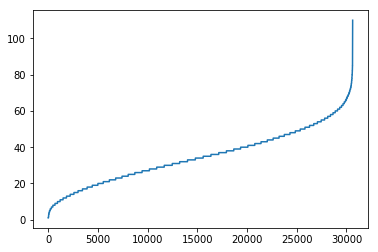

In [0]:
x_unpivot['bit_num'].plot()

In [0]:
x_unpivot_row = pd.DataFrame(x_flat[x_flat['value']==1].groupby('bitvector').apply(lambda x: list(x['rowID'])).reset_index(name='rowID'))
x_unpivot_row['row_num'] = [len(b) for b in x_unpivot_row['rowID']]
x_unpivot_row.head()

,bitvector,rowID,row_num
0,bitvector0,"[16, 40, 41, 71, 73, 74, 77, 81, 82, 118, 119,...",5995
1,bitvector1,"[71, 118, 138, 196, 204, 240, 310, 311, 320, 3...",1391
2,bitvector10,"[483, 676, 689, 719, 745, 771, 774, 920, 922, ...",1171
3,bitvector100,"[5138, 5139, 5140, 5174, 6292, 6915, 7030, 705...",2109
4,bitvector101,"[241, 242, 253, 378, 379, 380, 452, 561, 562, ...",5510


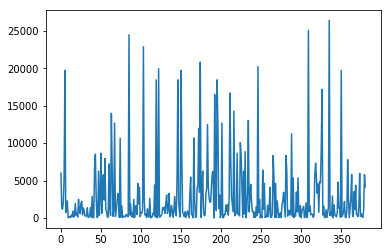

In [0]:
x_unpivot_row['row_num'].plot()

In [0]:
y_len = [df_y.iloc[i].sum() for i in range(len(df_y))]
pd.value_counts(y_len)

1     28376
2      1663
3       347
4       136
5        53
7        23
6        20
8         6
11        3
9         3
10        2
dtype: int64

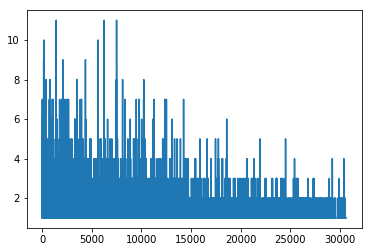

In [0]:
pd.Series(y_len).plot()

In [0]:
def findSim(rowID):
    bits = x_unpivot[x_unpivot['rowID']==rowID]['bitvector'].values[0]
    bit_num = x_unpivot[x_unpivot['rowID']==rowID]['bit_num'].values[0]
#     print(bit_num)
    vote = {}
    for bit in bits:
#         print(bit)
        rows = x_unpivot_row[x_unpivot_row['bitvector']==bit]['rowID'].values[0]
        for row in x_unpivot[x_unpivot['bit_num'].isin([bit_num])]['rowID']: # bit_num数相同的row，可以设置浮动
            if row in rows:
                if row in vote.keys():
                    vote[row] += 1
                else:
                    vote[row] = 1
    df_vote = pd.DataFrame(vote,index=[0]).T.sort_values(0,ascending=False).T
    df_vote.index=['rowID_Count']
    return df_vote

In [0]:
X_train.shape

(24505, 388)

# DL - FC network

In [5]:
from keras.layers import *
from keras.models import Model

x = input_x = Input(shape=[X_train.shape[1]], name='bitvectors')
x = Dense(128,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.1)(x)
y = Dense(37,activation='sigmoid')(x)

Model = Model(input_x, y)
Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
Model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bitvectors (InputLayer)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 37)                2405      
Total params: 141,861
Trainable params: 141,861
Non-trainable params: 0
_____________________________________________________

In [6]:
# Top25
Model.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=[X_test, y_test])

Train on 203 samples, validate on 61 samples
Epoch 1/25
203/203 [==============================] - 2s 9ms/step - loss: 0.6893 - accuracy: 0.5549 - val_loss: 0.6861 - val_accuracy: 0.6021
Epoch 2/25
203/203 [==============================] - 0s 85us/step - loss: 0.6849 - accuracy: 0.6031 - val_loss: 0.6810 - val_accuracy: 0.6619
Epoch 3/25
203/203 [==============================] - 0s 77us/step - loss: 0.6800 - accuracy: 0.6407 - val_loss: 0.6752 - val_accuracy: 0.6952
Epoch 4/25
203/203 [==============================] - 0s 75us/step - loss: 0.6740 - accuracy: 0.6806 - val_loss: 0.6686 - val_accuracy: 0.7187
Epoch 5/25
203/203 [==============================] - 0s 79us/step - loss: 0.6674 - accuracy: 0.6983 - val_loss: 0.6611 - val_accuracy: 0.7359
Epoch 6/25
203/203 [==============================] - 0s 83us/step - loss: 0.6600 - accuracy: 0.7207 - val_loss: 0.6524 - val_accuracy: 0.7497
Epoch 7/25
203/203 [==============================] - 0s 84us/step - loss: 0.6519 - accuracy: 0.73

In [0]:
from keras.layers import *
from keras.models import Model

x = input_x = Input(shape=[X_train.shape[1]])
x = Embedding(2,37)(x)

# x = Reshape((388,1))(x)
x = LSTM(128, return_sequences=True,activation='relu')(x)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
y = Dense(37,activation='sigmoid')(x)

Model_lstm = Model(input_x, y)
Model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
Model_lstm.summary()

In [0]:
Model_lstm.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=[X_test, y_test])

In [8]:
#Evaluation - sigmoid
y_pred_raw = Model.predict(X_test)
y_mean = 0.5 # 0.5
y_pred_raw[y_pred_raw>=y_mean] = 1
y_pred_raw[y_pred_raw<y_mean] = 0
y_pred = pd.DataFrame(y_pred_raw,index=y_test.index.values, columns=y_test.columns.values)
y_pred[y_pred==1].count().sum() / (y_pred.shape[0]*y_pred.shape[1])

0.027913159060700046

In [0]:
# Evaludation
# y_pred_raw = Model.predict(X_test)

y_mean = 0.328
y_pred = pd.DataFrame([[1 if i > y_mean else 0 for i in y_pred_raw[r]] for r in range(len(y_pred_raw))],index=y_test.index.values, columns=y_test.columns.values)

In [34]:
y_pred[y_pred==1].count().sum() / (y_pred.shape[0]*y_pred.shape[1])

0.23836951705804166

# Evaluatation


In [11]:
target = y_train[y_train==1].count().sum() / (y_train.shape[0]*y_train.shape[1])
target

0.23698575422713353

In [0]:
y_pred_raw = Model.predict(X_test)

def getRatio(m):
    pred = pd.DataFrame([[1 if i >= m else 0 for i in y_pred_raw[r]] for r in range(len(y_pred_raw))])    
    ratio = pred[pred==1].count().sum()/ (pred.shape[0]*pred.shape[1])
    return ratio

In [20]:
getRatio(0.5)

0.027913159060700046

In [21]:
#get the best y_mean
# y_mean = 1
record = []
learn_rate = 1
i=0
for i in range(20):
    # if getRatio(y_mean) < target:
    #     sgn = -1
    # else:
    #     sgn = 1
  sgn = getRatio(y_mean)-target
  if sgn*(getRatio(y_mean)-target) > 0:
    i += 1
    sgn = getRatio(y_mean)-target
    if len(record) < 2 or record[-1]*record[-2] > 0:
      learn_rate *= 2
    else:
      learn_rate = 5
    record.append(sgn)

    if abs(record[-1]) < 1.0e-05:
      learn_rate = 1
    elif abs(record[-1]) < 1.0e-06:
      learn_rate = 3
    y_mean += sgn*learn_rate
  else:
    print(-1)
  if len(record) > 3 and record[-1]==record[-2]==record[-3]:
    print(i,y_mean, getRatio(y_mean),sgn,learn_rate,'done')
    break
  print(i,y_mean, getRatio(y_mean),sgn,learn_rate)

1 0.8189066483911029 0.0 0.3004533241955515 2
2 -0.12903636851743117 1.0 -0.23698575422713353 4
3 3.6860348603469015 0.0 0.7630142457728665 5
4 2.501106089211234 0.0 -0.23698575422713353 5
5 1.3161773180755665 0.0 -0.23698575422713353 5
6 -1.0536802241957686 1.0 -0.23698575422713353 10 done


In [30]:
y_pred_raw = Model.predict(X_test)
#get the best y_mean
y_mean = 0.2
i=0
# for i in range(20):
#     if getRatio(y_mean) < target:
#         sgn = -1
#     else:
#         sgn = 1
sgn = getRatio(y_mean)-target
while sgn*(getRatio(y_mean)-target) > 0:
  i += 1
  sgn = getRatio(y_mean)-target
  y_mean += sgn
  print(i,y_mean, getRatio(y_mean),sgn)

1 0.547861387997058 0.018165706690296855 0.3478613879970579


In [35]:
print(y_mean, getRatio(y_mean),sgn)
y_pred = pd.DataFrame([[1 if i >= y_mean else 0 for i in y_pred_raw[r]] for r in range(len(y_pred_raw))],index=y_test.index.values, columns=y_test.columns.values)

0.328 0.23836951705804166 0.3478613879970579


In [36]:
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    hloss = sklearn.metrics.hamming_loss(y_test, y_pred)
    zero_one_loss = sklearn.metrics.zero_one_loss(y_test, y_pred)
    micro_precision = sklearn.metrics.precision_score(y_test, y_pred, average='micro')
    weighted_precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
    micro_recall = sklearn.metrics.recall_score(y_test, y_pred, average='micro')
    weighted_recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
    macro_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')
    micro_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='micro')
    weighted_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
    report =  sklearn.metrics.classification_report(y_test, y_pred)
    
    # list metrics and round them
    metrics = [accuracy, hloss, zero_one_loss, micro_recall, weighted_recall,
              micro_precision, weighted_precision, macro_f1, micro_f1, weighted_f1]
    rnd_metrics =  [round(x,2) for x in metrics]
    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
rnd_metrics

[0.0, 0.25, 1.0, 0.47, 0.47, 0.44, 0.35, 0.24, 0.45, 0.35]

In [38]:
print(report) 

              precision    recall  f1-score   support

           0       0.52      0.68      0.59        19
           1       0.59      0.79      0.68        24
           2       0.41      1.00      0.58        25
           3       0.45      0.71      0.55        24
           4       1.00      0.25      0.40        12
           5       0.50      0.75      0.60        24
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         9
          11       0.39      1.00      0.56        24
          12       0.50      0.14      0.22        14
          13       0.00      0.00      0.00         6
          14       0.33      1.00      0.49        20
          15       0.54      1.00      0.70        33
          16       0.41      0.75      0.53        16
          17       0.00    

In [0]:
y_test.sum()

C-C Bond Formation (Coupling)                         19
C-C Bond Formation (Methylation)                      24
C-N Bond Formation (N-methylation)                    25
C-O Bond Formation (Etherification)                   24
Functional Conversion (Hydroxy to methoxy)            12
Functional Introduction (Bromination)                 24
Functional Introduction (Hydroxylation)                9
Functional Introduction (Nitration)                   12
Synthesis (Pyrazole)                                   5
C-C Bond Formation (Acylation)                         5
C-C Bond Formation (Olefination)                       9
C-N Bond Formation (N-arylation)                      24
Functional Introduction (Iodination)                  14
C-C Bond Formation (Condensation)                      6
C-N Bond Formation (Amination)                        20
C-N Bond Formation (Condensation)                     33
C-N Bond Formation (N-acetylation)                    16
C-N Bond Formation (N-alkylatio